# SOM Visualization


## Description

This notebook contains code for visualizing the contents of hierarchical data (`*.h5`) files produced by [`Sompy_experimentation.ipynb`](Sompy_experimentation.ipynb). The current things it displays are as follows:

 - A set of linear-gradient heatmaps
 - A set of log-gradient heatmaps
 - An interactive interface for browsing through what items are in each cluster
 - A "U-matrix" that highlights regions of high euclidean distance gradients, to identify how well-matching the cluster boundaries are
 
 
 ## Workflow
 
 
 1. Enter the particular codebook file you want to use in [the codebook selection cell](#codebook_selection_cell), change the KM_CLUSTERS value to whatever number of clusters you feel is appropriate, and then rerun the notebook.
 1. Inspect the heatmaps in [the heatmap view cells](#heatmap_view_cell).
 1. Search the cells for materials of interest in [the cluster inspector cell](#cluster_inspector_cell).
 1. Evaluate the accuracy of the fit of the clusters in [the umatrix view cell](#umatrix_view_cell).
 
 
 ## Notes
 
  - The trained SOM has many arrays, one for each parameter it was trained on. This is what is seen in the heatmap views - each heatmap corresponds to one of these arrays.
  - The cluster inspector has various features, which shall be listed here.
      - First, each cluster is given its own tab in the inspector. The order of the tabs by color matches the pattern in the colorbar to the side of the cluster map. You can confirm the color of a given cluster with the colored square next to the cluster's name inside of the tab's frame.
      - When a cluster is selected, you may view its statistical information and contained items in the tables in the tab's frame.
      - You can restrict the number of items shown in the tab by entering a **regular expression**([1](https://en.wikipedia.org/wiki/Regular_expression), [2](https://www.regular-expressions.info/quickstart.html)) that matches the items you wish to see.
      - Once the items have been filtered to your liking, you can hit the "render points" button in order to display all items visible in the table to the cluster map.

In [1]:
import numpy as np
import pandas as pd
import logging
import ipywidgets as widgets
import matplotlib.pyplot as plt
import tables
import sompy
from sompy.visualization.mapview import View2D
from sompy.sompy import SOMFactory
import skimage
import matplotlib as mpl
from tfprop_sompy.tfprop_vis import render_cluster_borders_to_axes, dataframe_to_coords, render_points_to_axes
import sklearn.cluster as clust

In [2]:
# Codes from tfprop_sompy packages. Private code from Luna's group.
from tfprop_sompy.jupyter_integration.cluster_inspector import sort_materials_by_cluster, cluster_tabs,\
                                                                make_cluster_graph
from tfprop_sompy.tfprop_vis import render_posmap_to_axes, kmeans_clust, render_points_to_axes,\
                                    show_posmap, ViewTFP, dataframe_to_coords,\
                                    clusteringmap_category, UMatrixTFP

In [3]:
# This makes all the loggers stay quiet unless it's important
logging.getLogger().setLevel(logging.WARNING)

In [4]:
# Paste name of file generated by training in Sompy_experimentation
CODEBOOK_FILE = 'som_enamel_data.h5'

# Number of clusters for k-means clustering
KM_CLUSTERS = 6

In [5]:
# Creates necessary pd dataframes for visualization
stored_cb_matrix = pd.read_hdf(CODEBOOK_FILE, 'sm_codebook_matrix')
stored_mapsize = pd.read_hdf(CODEBOOK_FILE, 'sm_codebook_mapsize').values
mats_df = pd.read_hdf(CODEBOOK_FILE, 'sm_data')

# FIXME:
# We do a hack using the "pytables" library in order to extract the information
# For some reason pandas doesn't like to read object series out of h5 files

stored_columns = None
stored_matfamilies = None
with tables.open_file(CODEBOOK_FILE, "r") as store:
    # We normally get byte strings from this
    # The mapping operation turns them all into unicode strings ready for presentation
    
    # Obtaining the column names
    stored_columns = list(map(lambda x: x.decode('utf-8'), store.root.sm_codebook_columns.property_names.read()))
    
    # Obtaining the material identification
    stored_matfamilies = list(map(lambda x: x, store.root.sm_codebook_matfamilies.material_families.read()))

In [6]:
mats_df

,modulus,hardness,carb,crys,fluo,age,tooth_label,mammal,age_group,position,depth,kc,b
0,76.07,4.17,0.08,12.21,962.65,6,6j,h,p,outer,1.00,1.02,258.34
1,75.07,4.45,0.09,12.53,962.60,6,6j,h,p,outer,0.80,0.93,277.70
2,74.10,3.91,0.10,12.77,962.61,6,6j,h,p,middle,0.60,1.02,243.59
3,68.91,3.94,0.11,12.95,962.51,6,6j,h,p,middle,0.40,1.00,244.44
4,63.81,3.11,0.12,13.18,962.68,6,6j,h,p,inner,0.20,0.92,264.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,64.80,3.47,0.10,13.06,960.71,10,10,o,wad,outer,0.77,1.02,352.11
134,59.40,3.32,0.11,13.35,960.65,10,10,o,wad,middle,0.59,1.04,304.30
135,56.92,2.89,0.12,13.53,960.57,10,10,o,wad,middle,0.39,1.07,305.00
136,57.43,3.09,0.12,13.66,960.50,10,10,o,wad,inner,0.21,1.14,259.27


In [7]:
# Insert new column with material identification
mats_df["Row"] = stored_matfamilies

In [8]:
# Function located in sompy.py
# Creates a SOM object
sm = SOMFactory.build(mats_df[stored_columns].values, 
                mapsize=(*stored_mapsize,),
                normalization="var", 
                initialization="pca", 
                component_names=stored_columns)

In [9]:
# SOM object contains a codebook object
# Setting the matrix to the values of our current data. 
sm.codebook.matrix = stored_cb_matrix.values

In [10]:
# Using scikit-learn K-means clustering method to predict cluster fit index for our SOM object.
cl_labels = kmeans_clust(sm, KM_CLUSTERS)

Performing K-means clustering to SOM trained data...


In [11]:
# This returns our function used to "filter"
# our output in order to make differences more exaggerated
def create_knee_function(cutoff: float, middle: float, maxm: float, minm: float):
    def new_knee(x: float):
        # [-1,1] value determining closeness to "extremes"
        if x < middle:
            diff = 0.5*(x-middle)/(middle-minm)
        else:
            diff = 0.5*(x-middle)/(maxm-middle)
        # 0 if we're below our cutoff
        if np.abs(diff) < cutoff:
            return middle
        # Linearly interpolate between our middle and the boundary
        else:
            if diff < 0:
                interp_diff = (diff + cutoff)/(0.5 - cutoff)
                return middle + interp_diff*(middle - minm)
            else:
                interp_diff = (diff - cutoff)/(0.5 - cutoff)
                return middle + interp_diff*(maxm - middle)
    return new_knee

class ViewTFP2(View2D):
    """Map viewer override that allows for specifying the normalization method"""
    
    def __init__(self, *args, knee_value=0, stdev_colorscale_coeff=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.knee_value = knee_value
        self.stdev_colorscale_coeff = stdev_colorscale_coeff

    def _calculate_figure_params(self, som, which_dim, col_sz,
                                 width=None, height=None):
        """ Class method in MapView._calculate_figure_params() overrided """
        codebook = som._normalizer.denormalize_by(som.data_raw,
                                                  som.codebook.matrix)

        indtoshow, sV, sH = None, width, height

        if which_dim == 'all':
            dim = som._dim
            row_sz = np.ceil(float(dim) / col_sz)
            msz_row, msz_col = som.codebook.mapsize
            ratio_hitmap = msz_row / float(msz_col)
            ratio_fig = row_sz / float(col_sz)
            indtoshow = np.arange(0, dim).T
            sH, sV = (width, height) or (16, 16*ratio_fig*ratio_hitmap)

        elif type(which_dim) == int:
            dim = 1
            msz_row, msz_col = som.codebook.mapsize
            ratio_hitmap = msz_row / float(msz_col)
            indtoshow = np.zeros(1)
            indtoshow[0] = int(which_dim)
            sH, sV = (width, height) or (16, 16*ratio_hitmap)

        elif type(which_dim) == list:
            max_dim = codebook.shape[1]
            dim = len(which_dim)
            row_sz = np.ceil(float(dim) / col_sz)
            msz_row, msz_col = som.codebook.mapsize
            ratio_hitmap = msz_row / float(msz_col)
            ratio_fig = row_sz / float(col_sz)
            indtoshow = np.asarray(which_dim).T
            sH, sV = (width, height) or (16, 16*ratio_fig*ratio_hitmap)

        no_row_in_plot = dim / col_sz + 1  # 6 is arbitrarily selected
        if no_row_in_plot <= 1:
            no_col_in_plot = dim
        else:
            no_col_in_plot = col_sz

        axis_num = 0

        width = sH
        height = sV

        return (width, height, indtoshow, no_row_in_plot, no_col_in_plot,
                axis_num)

    def prepare(self, *args, **kwargs):
        self._close_fig()
        self._fig = plt.figure(figsize=(self.width, self.height))
        self._fig.suptitle(self.title)
        plt.rc('font', **{'size': self.text_size})

# NOTE: I'm using type rST syntax right now because I don't want to make
# excessive changes to make this use python's formal typing system.
# We may want to move to python's typing system later
    def show(self, som :sompy.sompy.SOM, cl_labels :list, what='codebook', which_dim='all',
             cmap=None, col_sz=None, desnormalize=False, col_norm=None, normalizer="linear", savepath="",
             isOutHtmap=True):
        """ Class method in View2D.show() overridden
        
        There's now an extra parameter, "col_norm", which is used to determine whether to normalize by
        the median or the mean
        :param som: The self-organizing map to visualize
        :type som: sompy.sompy.SOM
        :param cl_labels: Cluster labels (?)
        :type cl_labels: list
        :param what: unused
        :type what: str
        :param which_dim: Which dimensions to display
        :type which_dim: "all" or int or list
        :param cmap: The color map to use for the plot
        :type cmap: matplotlib.colors.Colormap
        :param col_sz: Number of columns
        :type col_sz: integer
        :param desnormalize: Whether or not to denormalize the codebook
        :type desnormalize: Boolean
        :param col_norm: Determines what "middle value" to use for normalization
        :type col_norm: "median" or "mean"
        :param normalizer: Which normalizer to use
        :type normalizer: "linear" or "log"
        """
        (self.width, self.height, indtoshow, no_row_in_plot, no_col_in_plot,
         axis_num) = \
            self._calculate_figure_params(som, which_dim, col_sz,
                                          width=self.width, height=self.height)
        self.prepare()
        # Mathtext font to sans-serif
        mpl.rcParams['mathtext.fontset'] = 'custom'
        mpl.rcParams['mathtext.rm'] = 'sans\-serif'
        mpl.rcParams['mathtext.cal'] = 'sans\-serif'

        cmap = cmap or plt.get_cmap('RdYlBu_r')

        if not desnormalize:
            codebook = som.codebook.matrix
        else:
            codebook = som._normalizer.denormalize_by(som.data_raw,
                                                      som.codebook.matrix)

        if which_dim == 'all':
            names = som._component_names[0]
        elif type(which_dim) == int:
            names = [som._component_names[0][which_dim]]
        elif type(which_dim) == list:
            names = som._component_names[0][which_dim]

        while axis_num < len(indtoshow):
            axis_num += 1
            ax = plt.subplot(no_row_in_plot, no_col_in_plot, axis_num)
            ind = int(indtoshow[axis_num-1])

            if col_norm == 'median':  # normalized by median        
                middle_point = np.median(codebook[:, ind].flatten())
            else: # normalized by mean
                middle_point = np.mean(codebook[:, ind].flatten())

            cb_min = np.min(codebook[:, ind].flatten())
            cb_max = np.max(codebook[:, ind].flatten())

            min_color_scale = middle_point - self.stdev_colorscale_coeff \
                * np.std(codebook[:, ind].flatten())
            max_color_scale = middle_point + self.stdev_colorscale_coeff \
                * np.std(codebook[:, ind].flatten())
            min_color_scale = min_color_scale if min_color_scale >= \
                cb_min else cb_min
            max_color_scale = max_color_scale if max_color_scale <= \
                cb_max else cb_max
            
            # FIXME: Break this out into less hacked-in code
            # "Middle color" should be mean or median?
            # The min value should be at the bottom of the range
            # The max value should be at the top of the range
            # The "min_color_scale" value should be the absolute bottom of the original color range
            # The "max_color_scale" value should be the absolute top of the original color range
            # .5 - .5 * min((middle_point - min_color_scale) / (middle_point - cb_min), 1)
            # .5 + .5 * min((middle_point - max_color_scale) / (middle_point - cb_max), 1)
            # 
            # I probably can reorder this to make more sense
            # FIXME: This code currently biases the colors in a not very useful manner
            #cmap_bottom = .5 * (1 - min((middle_point - min_color_scale) / (middle_point - cb_min), 1))
            #cmap_top = .5 * (1 + min((middle_point - max_color_scale) / (middle_point - cb_max), 1))
            #my_cmap = ListedColormap(cmap(np.linspace(cmap_bottom, cmap_top, num=512)))
            my_cmap = cmap
            if normalizer == 'log':
                norm = mpl.colors.SymLogNorm(linthresh=(max_color_scale-min_color_scale)/100, vmin=0.7*min_color_scale,
                                          vmax=max_color_scale,
                                          clip=True)
            else:
                norm = mpl.colors.Normalize(vmin=min_color_scale*0.5,
                                            vmax=max_color_scale,
                                            clip=True)

            mp = codebook[:, ind].reshape(som.codebook.mapsize[0],
                                          som.codebook.mapsize[1])
            # FIXME: Break this out into less hacked-in code
            # Insert the scaling function here
            # as-is this is likely very slow - an immediate improvement would come
            # from using something such as "numba" here
            scaler = np.vectorize(create_knee_function(self.knee_value, middle_point, np.max(codebook[:, ind].flatten()), np.min(codebook[:, ind].flatten())))
            pl = ax.pcolormesh(scaler(mp.T), norm=norm, cmap=my_cmap)
            ax.set_xlim([0, som.codebook.mapsize[0]])
            ax.set_ylim([0, som.codebook.mapsize[1]])
            ax.set_aspect('equal')
            ax.set_title(names[axis_num - 1],fontsize=22)
            # Disable ticks and tick labels
            disable_ticks = ["labelbottom", "labelleft", "bottom", "left", "right", "top"]
            disable_ticks_dict = {a: False for a in disable_ticks}
            # This unpacks the dict into the keyword arguments,
            # setting them all as false without needing to write each one out
            ax.tick_params(**disable_ticks_dict)

            plt.colorbar(pl, ticks=None, shrink=1, fraction=0.046, pad=0.00441) # format='%.1f', 


            # draw line segment to the border of cluster
            msz = som.codebook.mapsize

            for i in range(len(cl_labels)):
                rect_x = [i // msz[1], i // msz[1],
                          i // msz[1] + 1, i // msz[1] + 1]
                rect_y = [i % msz[1], i % msz[1] + 1,
                          i % msz[1] + 1, i % msz[1]]

                if i % msz[1] + 1 < msz[1]:  # top border
                    if cl_labels[i] != cl_labels[i+1]:
                        ax.plot([rect_x[1], rect_x[2]],
                                [rect_y[1], rect_y[2]], 'k-', lw=4)

                if i + msz[1] < len(cl_labels):  # right border
                    if cl_labels[i] != cl_labels[i+msz[1]]:
                        ax.plot([rect_x[2], rect_x[3]],
                                [rect_y[2], rect_y[3]], 'k-', lw=4)
                               

        # plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.tight_layout()
        plt.show()
        
        # save figure of heat map
        if isOutHtmap:
            print("Saving figure of heat map for all thermofluid prop. to {}...".format(savepath))
            self._fig.savefig(savepath)

In [12]:
# Setting parameters for our heatmap
heatmap_size = (50, 50)
heatmap_col_sz = 1
gauss_alpha = None

cmap = plt.get_cmap('RdYlBu_r')  # set color map using Matplolib function

#Initializing a map viewer imported from mapview.py
viewTFP = ViewTFP(*heatmap_size, '', stdev_colorscale_coeff=1., text_size=20)
viewTFP2 = ViewTFP2(*heatmap_size, '', stdev_colorscale_coeff=1., text_size=24)

In [13]:
# Initializing widget
my_out = widgets.Output()

# No scaling
viewTFP.knee_value = 0.00

# Displaying heatmap through the widget
# Uses matplotlib functions

with my_out:
    print("Linear scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz, 
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap, isOutHtmap=True)

my_out

Output()

<ipython-input-11-e54ed6dc4a3c>:142: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(no_row_in_plot, no_col_in_plot, axis_num)


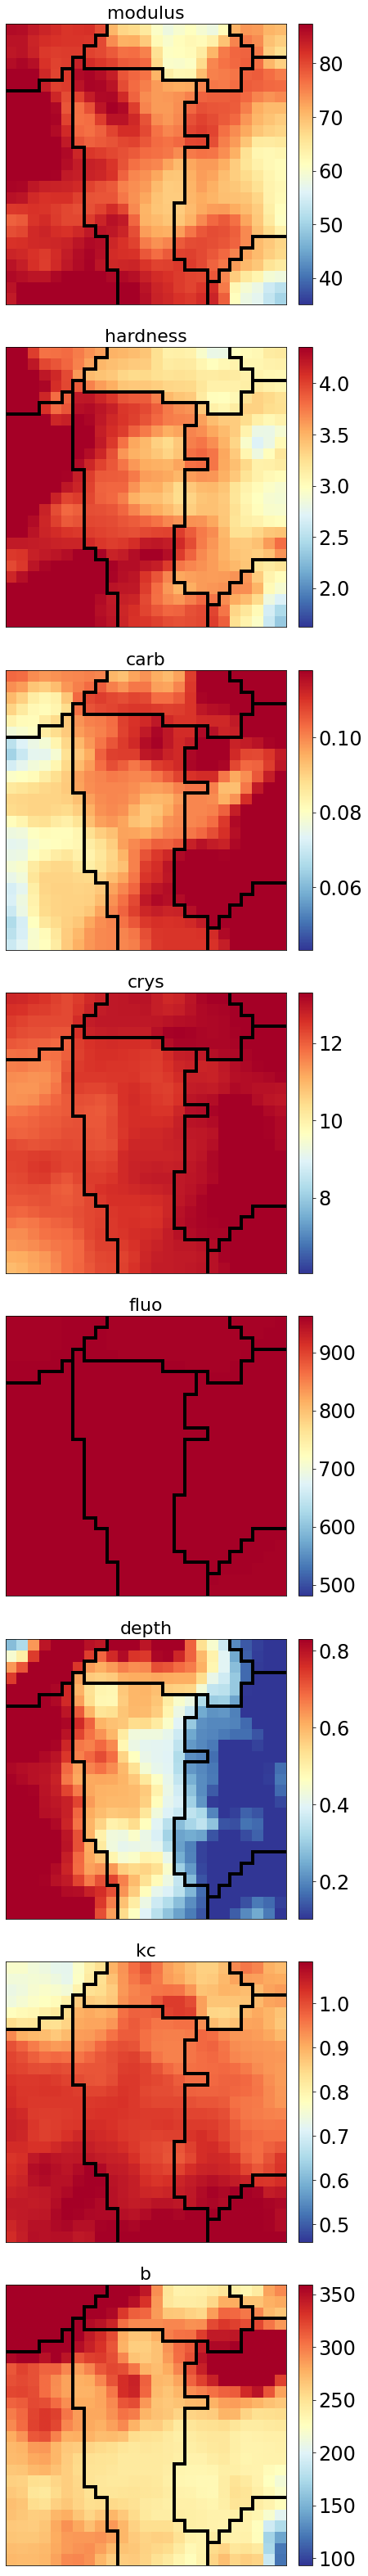

Saving figure of heat map for all thermofluid prop. to ...


In [14]:
####### Produce Heat Maps #######

# No scaling
viewTFP2.knee_value = 0.00

viewTFP2.show(sm, cl_labels, col_sz=heatmap_col_sz, 
                         which_dim='all', desnormalize=True, col_norm='median',
                         cmap=cmap, isOutHtmap=True)

# Dont Use These For This Set Up
# ax1 = cbar.ax
# ax1.set_position([1,0.5,0.5,.1])

In [15]:
my_out = widgets.Output() # Initializing widget
cmap = plt.get_cmap('RdYlBu_r')  # set color map 'viridis' 'RdYlBu_r'

# No scaling
viewTFP.knee_value = 0.0
with my_out:
    print("Log scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap, normalizer="log")
my_out

Output()

In [16]:
mats_df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            128, 129, 130, 131, 132, 133, 134, 135, 136, 137],
           dtype='int64', length=138)

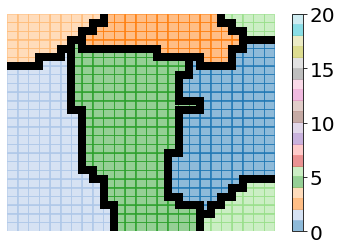

In [17]:
# Creating 2-D list organized by clusters
# 5 cluster = 5 lists within this list
clusters_list = sort_materials_by_cluster(sm, mats_df, cl_labels)

# This makes it so it will display the full lists
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# This should be the last statement of the cell, to make it display
# That, or assign the return value to a variable, and have that variable be the final expression in a cell
cluster_tabs(sm, mats_df, clusters_list, cl_labels)

In [18]:
mats_df["Row"] = None

In [19]:
# cluster number -> color graph
def make_cluster_graph(mysom: sompy.sompy.SOM, cl_labels: np.ndarray):
    Col1=6 #Total figure width
    pl1=2.7 #Drawing area width
    AR=14.63/18.47 #Height/width of figure.

    fig, ax = plt.subplots(figsize=[Col1,Col1*AR])
    #fig, ax = plt.subplots(1, 1)
    n_palette = 20
    cmap = plt.get_cmap("tab20")
    norm = mpl.colors.Normalize(vmin=0, vmax=n_palette, clip=True)
    msz = mysom.codebook.mapsize
    pl = ax.pcolormesh(cl_labels.reshape(msz[0], msz[1]).T % n_palette,
                  cmap=cmap, norm=norm, edgecolors='face',
                  lw=0.5, alpha=0.5)
    render_cluster_borders_to_axes(ax, cl_labels, msz)
    ax.axis('off')
    plt.tight_layout(rect=[0,0,1,1])
    fig.colorbar(pl, ax=ax)
    return fig, ax

In [20]:
# This function prints labels on cluster map
def clusteringmap_category(sm,n_clusters,dataset,colorcategory,labels, savepath):
    """
    Description:
    This function is used to output maps that prints colors on dots based
    on their properties
    """
    categories = dataset[colorcategory] #if colorcategory is one col of the dataset
    cmap = plt.get_cmap("Greys") #cmap for background
    n_palette = 100000  # number of different colors in this color palette
    color_list = [cmap((i % n_palette)/n_palette) for i in range(n_clusters)]
    msz = sm.codebook.mapsize
    proj = sm.project_data(sm.data_raw)
    coord = sm.bmu_ind_to_xy(proj)

    fig, ax = plt.subplots(1, 1, figsize=(30,30))

    cl_labels = clust.KMeans(n_clusters=n_clusters,random_state=555).fit_predict(sm.codebook.matrix)
        
    # fill each rectangular unit area with cluster color
    #  and draw line segment to the border of cluster
    norm = mpl.colors.Normalize(vmin=0, vmax=n_palette, clip=True)
    ax.pcolormesh(cl_labels.reshape(msz[0], msz[1]).T % n_palette,
                cmap=cmap, norm=norm, edgecolors='face',
                lw=0.5, alpha=0.5)

    ax.scatter(coord[:, 0]+0.5, coord[:, 1]+0.5, c='k', marker='o')
    ax.axis('off')

    categoryname = list(dataset.groupby(colorcategory).count().index)
    categories_int = categories.apply(categoryname.index)

    N = len(categoryname)
    cmap_labels = plt.cm.brg
    # extract all colors from the .jet map
    cmaplist = [cmap_labels(i) for i in range(cmap_labels.N)]
    # create the new map
    cmap_labels = cmap_labels.from_list('Custom cmap', cmaplist, cmap_labels.N)
    # define the bins and normalize
    bounds = np.linspace(0,N,N+1)
    norm_labels = mpl.colors.BoundaryNorm(bounds, cmap_labels.N)

    scat = ax.scatter(coord[:, 0]+0.5, coord[:, 1]+0.5, c=categories_int,s=1000,cmap=cmap_labels,norm=norm_labels)
    cbar = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cbar.ax.get_yaxis().set_ticks([])
    
    for j, lab in enumerate(categoryname):
        cbar.ax.text(1, (2 * j + 1) / (2*(len(categoryname))), lab, ha='left', va='center', fontsize=0)
    cbar.ax.get_yaxis().labelpad = 15
    # cbar.ax.set_ylabel('# of contacts', rotation=270)
    ax.axis('off')
    
    
    for label, x, y in zip(labels, coord[:, 0], coord[:, 1]):
        x += 0.2
        y += 0.2
        # "+ 0.1" means shift of label location to upperright direction

        # randomize the location of the label
        #   not to be overwrapped with each other
        x += 0.1 * np.random.randn()
        y += 0.3 * np.random.randn()

        # wrap of label for chemical compound
        #label = str_wrap(label)

        ax.text(x+0.4, y+0.4, label, horizontalalignment='left', verticalalignment='bottom',rotation=30, fontsize=12, weight='semibold')
    # cl_labels = som.cluster(n_clusters)
    cl_labels = clust.KMeans(n_clusters = n_clusters, random_state = 555).fit_predict(sm.codebook.matrix)

    for i in range(len(cl_labels)):
        rect_x = [i // msz[1], i // msz[1],
                i // msz[1] + 1, i // msz[1] + 1]
        rect_y = [i % msz[1], i % msz[1] + 1,
                i % msz[1] + 1, i % msz[1]]

        if i % msz[1] + 1 < msz[1]:  # top border
            if cl_labels[i] != cl_labels[i+1]:
                ax.plot([rect_x[1], rect_x[2]],
                        [rect_y[1], rect_y[2]], 'k-', lw=8)

        if i + msz[1] < len(cl_labels):  # right border
            if cl_labels[i] != cl_labels[i+msz[1]]:
                ax.plot([rect_x[2], rect_x[3]],
                        [rect_y[2], rect_y[3]], 'k-', lw=8)

    plt.savefig(savepath)
    return cl_labels, ax, fig

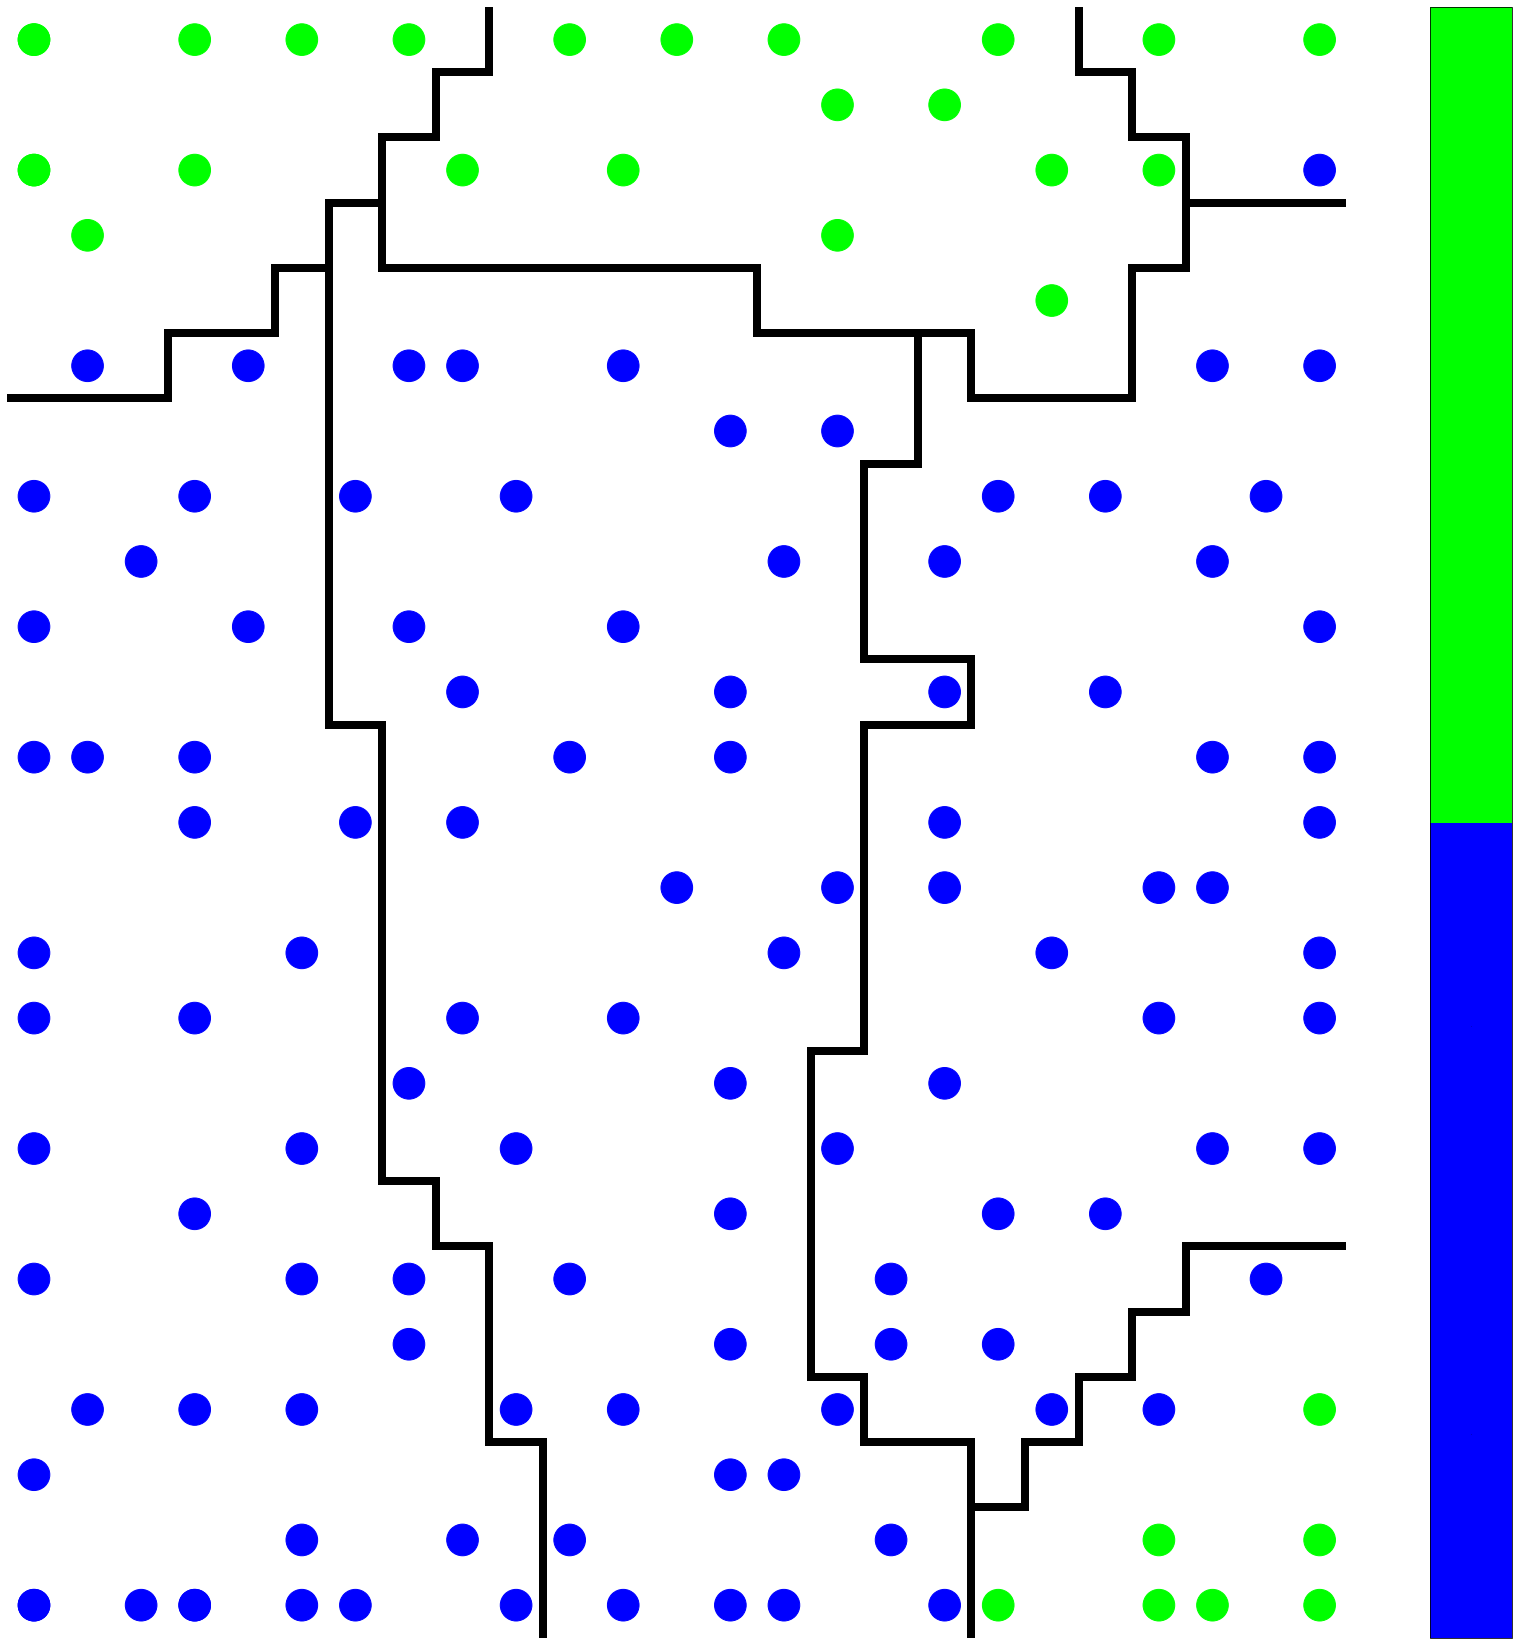

In [21]:
# Generating another cluster map to overlay material identification

############## Figure widths in inches, nature standard ##############

# fig, ax = make_cluster_graph(sm, cl_labels)

# Labels material identification on each data points on the cluster map
# Requires a column for color category
cl_labels, ax, fig = clusteringmap_category(sm, KM_CLUSTERS, mats_df, "mammal", mats_df["Row"],'plot.png')

#ax1 = fig.get_axes()

#ax1[1].set_position([.5,.5,.5,.5])

# ax.properties()

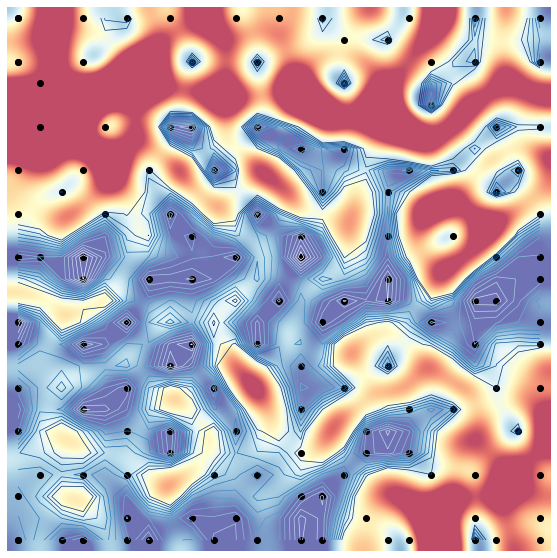

Saving figure of U-matrix to umatrix.png...


([],
 array([[0.37317606, 0.39076175, 0.40042121, 0.42511023, 0.44975078,
         0.35097839, 0.32043691, 0.36475934, 0.42360291, 0.30913562,
         0.24243348, 0.52641792, 0.48334425, 0.31473974, 0.44209173,
         0.53833193, 0.5818204 , 0.66123886, 0.99376887, 1.34276046,
         1.41531033, 0.85840399, 0.57019541, 0.63102414, 0.51195197],
        [0.42662793, 0.41189165, 0.43859362, 0.41482191, 0.4609754 ,
         0.47122165, 0.42601603, 0.41656121, 0.42878985, 0.4039293 ,
         0.39200667, 0.53754726, 0.44018139, 0.33043614, 0.46359715,
         0.55255457, 0.53598171, 0.73455124, 0.89999592, 0.91520203,
         1.03860161, 0.83883411, 0.72555258, 0.77373092, 0.76075039],
        [0.35112846, 0.43128235, 0.53232877, 0.44205611, 0.50435585,
         0.54254445, 0.40738645, 0.46144375, 0.42344022, 0.39044725,
         0.54622528, 0.51302932, 0.33044715, 0.32762093, 0.53358436,
         0.65025542, 0.48458573, 0.62345564, 0.88666111, 1.17592573,
         1.24925753, 0.8921

In [22]:
# Initializing size
umat_size = (50, 50)

# Utilizes SOMPY's UMatrixView, which uses matplotlib
umat = UMatrixTFP(*umat_size, 'U-matrix')

# Plots the UMatrix map
# Must set "ifOutUmat" to True in order to output a image file
umat.show(sm, mats_df, mats_df, 'umatrix.png',cmap=cmap, isOutUmat=True)

In [23]:
# Calculate quantization error value
sm.calculate_quantization_error()

0.09080619458930875

In [24]:
# Calculate topographic error value
sm.calculate_topographic_error()

0.014492753623188406